# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.utils import shuffle
import os, argparse, random, pickle, cv2, fnmatch
from os.path import join
from scipy import stats
from tensorflow.keras.optimizers import RMSprop
import random
import gc
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

print('Using Tensorflow version: {}, and Keras version: {}'.format(tf.__version__, keras.__version__))


Using Tensorflow version: 1.13.1, and Keras version: 2.2.4-tf


# Loading Numpy Arrays

In [2]:
print('[INFO] Loading Data & Labels...')

final_Array = np.load('Images_Data.npy')
final_Labels = np.load('Images_Labels.npy')
final_ImagePath = np.load('Image_Path.npy')

print('[INFO] Data loaded')

[INFO] Loading Data & Labels...
[INFO] Data loaded


# Visualising Data

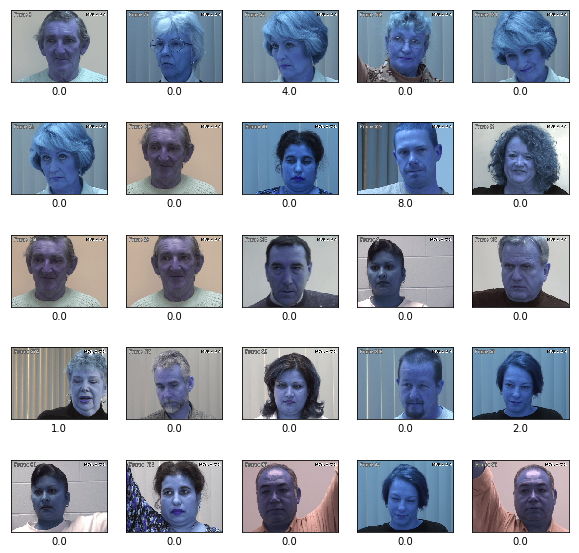

In [3]:
plt.figure(figsize=(10,10))
 
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(final_Array[i], cmap=plt.cm.binary)
    plt.xlabel(final_Labels[i])
plt.show()

# Splitting the Data

In [4]:
randomize = np.arange(len(final_Labels))
np.random.shuffle(randomize)
final_Labels = final_Labels[randomize]
final_Array = final_Array[randomize]
final_ImagePath = final_ImagePath[randomize]


test_ratio = 0.2
split_location = int(final_Array.shape[0]*(1-test_ratio))
train_data = final_Array[:split_location]
test_data = final_Array[split_location:]

train_labels = final_Labels[:split_location]
test_labels = final_Labels[split_location:]

train_imgpath = final_ImagePath[:split_location]
test_imgpath = final_ImagePath[split_location:]

print('Train Data\t: {}\nTrain Labels\t: {}\nTest Data\t: {}\nTest Labels\t: {}\nImage Path Train\t: {}\nImage Path Test\t: {}'
      .format(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape, train_imgpath.shape, test_imgpath.shape))

Train Data	: (13391, 240, 320, 3)
Train Labels	: (13391,)
Test Data	: (3348, 240, 320, 3)
Test Labels	: (3348,)
Image Path Train	: (13391,)
Image Path Test	: (3348,)


In [5]:
train_data = train_data.reshape((13391, 240, 320, 3))
train_data = train_data.astype('float32') / 255

In [6]:
test_data = test_data.reshape((3348, 240, 320, 3))
test_data = test_data.astype('float32') / 255

In [7]:
for i in range(len(train_labels)):
    if train_labels[i] >= 1.0:
        train_labels[i] = 1
    else:
        train_labels[i] = 0

for i in range(len(test_labels)):
    if test_labels[i] >= 1.0:
        test_labels[i] = 1
    else:
        test_labels[i] = 0


In [8]:
test_labels.mean(), train_labels.mean()

(0.501194743130227, 0.49966395340153835)

In [9]:
sum(test_labels), sum(train_labels)

(1678.0, 6691.0)

In [10]:
len(test_imgpath), len(train_imgpath)

(3348, 13391)

# Define Functions and Classes

In [11]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Accuracy')
    plt.ylim([min(history.history['acc'])-0.1,1])
    plt.legend()
    plt.show()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 4)
    #(monitor='val_loss', patience=3)
    
def plot_image(i, predictions, test_labels, img, threshold):
    prediction, true_label, img = float(predictions[i]), float(test_labels[i]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
 
    plt.imshow(img, cmap=plt.cm.binary)

    #predicted_label = np.argmax(predictions_array)
    if np.abs(prediction - true_label) < threshold:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'Predicted: {prediction:.2f}, True: {true_label:.2f}', color=color)

# Tensorflow Model
### Build

In [13]:
# def build_model():
#     model = keras.Sequential([
#       keras.layers.Flatten(),
#       keras.layers.Dense(1280, activation=tf.nn.relu),
#       tf.keras.layers.Dropout(0.2),
#       tf.keras.layers.Dense(1)#(16, activation=tf.nn.softmax)
#     ])

# #    model.compile(optimizer=tf.train.AdamOptimizer(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#     model.compile(optimizer=tf.train.AdamOptimizer(), loss = 'mean_squared_error', metrics = ['mean_absolute_error','mean_squared_error'])
    
#     #model.compile(optimizer=tf.keras.optimizers.RMSprop(0.1), 
#     #              loss = 'mean_squared_error', 
#     #              metrics = ['mean_absolute_error', 'mean_squared_error'])
#     return model

# def create_and_compile_model(): 
#     model = k.models.Sequential([
#         k.layers.Conv2D(4, (3,3), activation='relu', input_shape=(*config['target_size'], 3),  name='mh-conv-1')
#         , k.layers.MaxPooling2D(4, 4, name='mh-maxpool-1')
#         , k.layers.Conv2D(8, (3,3), activation='relu', name='mh-conv-2')
#         , k.layers.MaxPooling2D(4,4, name='mh-maxpool-2')
# #         , k.layers.Conv2D(64, (3,3), activation='relu', name='mh-conv-3')
# #         , k.layers.MaxPooling2D(2,2, name='mh-maxpool-3')
# #         , k.layers.Conv2D(128, (3,3), activation='relu', name='mh-conv-4')
# #         , k.layers.MaxPooling2D(4,4, name='mh-maxpool-4')
#         , k.layers.Flatten(name='mh-flatten-1')
#         , k.layers.Dense(128, activation='relu', name='mh-dense-1')
#         , k.layers.Dense(1, activation='sigmoid', name='mh-dense-output')
#     ])
    
#     model.compile(
#         optimizer=RMSprop(lr=0.001)
#         , loss='binary_crossentropy'
# #         , metrics=[keras_metrics.precision(), keras_metrics.recall()]
#         , metrics=['accuracy']
#     )
    
#     return model

In [12]:
def build_model(num_layers, window_size, filters, drpout): 
    
    cnn_config = [keras.layers.Conv2D(filters, (window_size,window_size), activation=tf.nn.relu, input_shape=(240, 320, 3), padding = 'same', name='pain-conv-1')
                  , keras.layers.MaxPooling2D(4, 4, name='pain-maxpool-1')]
    
    for i in range(2,num_layers+1,1):
        cnn_config.append(keras.layers.Conv2D(filters*i, (window_size, window_size), activation=tf.nn.relu, name='pain-conv-' + str(i)))
        cnn_config.append(keras.layers.MaxPooling2D(4, 4, name='pain-maxpool-' + str(i)))
        
    cnn_config.append(keras.layers.Flatten(name='pain-flatten-1'))
    cnn_config.append(keras.layers.Dropout(drpout))
    cnn_config.append(keras.layers.Dense(128, activation=tf.nn.relu, name='pain-dense-1'))
    cnn_config.append(keras.layers.Dropout(drpout))
    cnn_config.append(keras.layers.Dense(1, activation='sigmoid', name='pain-dense-output'))
    
    
    model = keras.Sequential(cnn_config)
    model.compile(
        optimizer=RMSprop(lr=0.001)
        , loss='binary_crossentropy'
        , metrics=['accuracy', 'binary_crossentropy']
    )
    return model

### Training

In [13]:
model = None 
try:
    del model
    print('Model cleared')
except:
    pass

try:
    keras.backend.clear_session()
    gc.collect()
    print('Session cleared')
except:
    pass
    

model = build_model(2, 3, 4, 0.2)
model.summary()


Model cleared
Session cleared
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pain-conv-1 (Conv2D)         (None, 240, 320, 4)       112       
_________________________________________________________________
pain-maxpool-1 (MaxPooling2D (None, 60, 80, 4)         0         
_________________________________________________________________
pain-conv-2 (Conv2D)         (None, 58, 78, 8)         296       
_________________________________________________________________
pain-maxpool-2 (MaxPooling2D (None, 14, 19, 8)         0         
_________________________________________________________________
pain-flatten-1 (Flatten)     (None, 2128)              0         
_________________________________________________________

In [14]:
history = model.fit(train_data, 
                    train_labels, 
                    epochs=20, 
                    batch_size=128,
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])
print('\nFitting Done!')

Instructions for updating:
Use tf.cast instead.

...............
Fitting Done!


### Evaluation

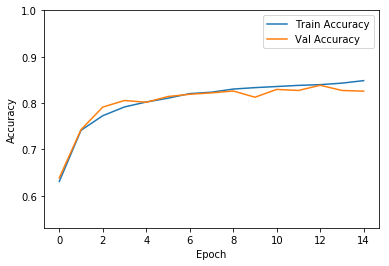

In [15]:
plot_history(history)

In [16]:
model.evaluate(test_data, test_labels)

3348/3348 [==============================] - 3s 1ms/sample - loss: 0.3918 - acc: 0.8292 - binary_crossentropy: 0.3918


[0.39177554142589066, 0.82915175, 0.39177555]

### Samples

FIRST 25 PICTURES OF DATASET


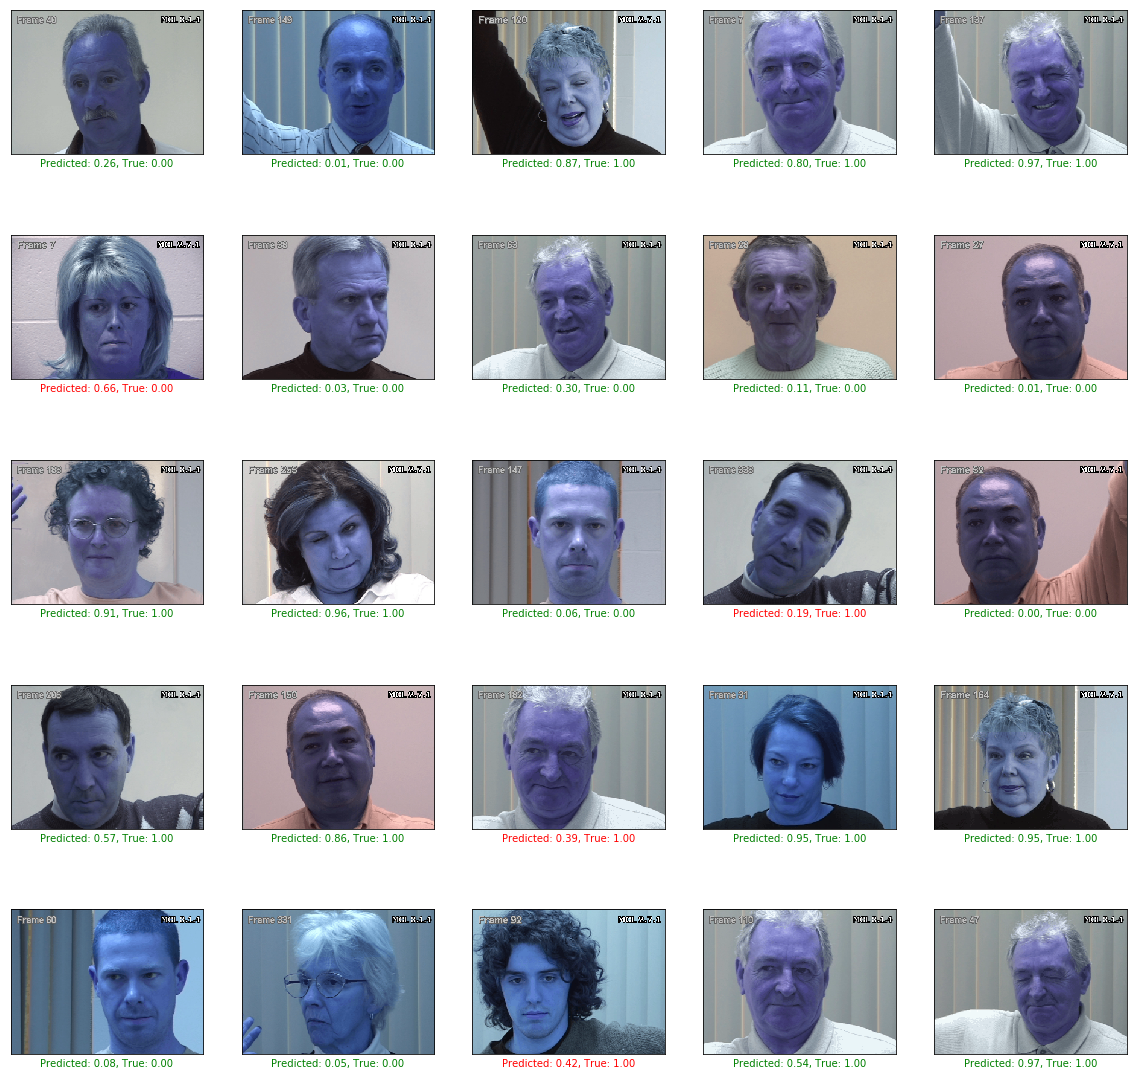

In [21]:
predictions = model.predict(test_data)
print("FIRST 25 PICTURES OF DATASET")
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*2*num_rows))
for i in range(num_images):
    j = random.randint(0,len(test_labels))
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(j, predictions, test_labels, test_data, 0.49)
plt.show()

### Confusion Matrix

[Text(0, 0.5, 'no pain'), Text(0, 1.5, 'pain')]

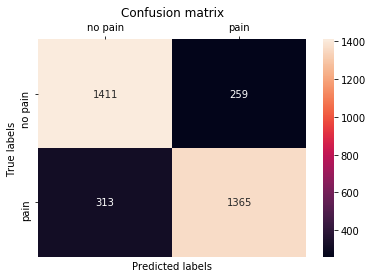

In [22]:
predictions = np.around(predictions, decimals=0)
cm = confusion_matrix(test_labels, predictions)

# plot heatmap of confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
plt.title('Confusion matrix', y=1.08)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.tick_top()
ax.xaxis.set_ticklabels(['no pain', 'pain'])
ax.yaxis.set_ticklabels(['no pain', 'pain'])

### Save Train + Test Data

In [22]:
# np.save('train_data',train_data)
# np.save('train_labels', train_labels)
# np.save('test_data', test_data)
# np.save('test_labels', test_labels)
# np.save('train_imgpath', train_imgpath)
# np.save('test_imgpath', test_imgpath)

### Data Augmentation

In [28]:
blk = 200
iterations = train_data.shape[0]//blk
last_blk = train_data.shape[0]%blk
iterations, last_blk

(66, 191)

In [30]:
for i in range(iterations):
    blk = 200
    aug_train_data = np.array([])
    cnt = 0
    for image in train_data[blk*i:blk*(i+1)]:
        new_image = np.array([])
        print(f'{cnt:03}', end='\r')
        cnt+=1
        for row in image:
            if len(new_image) > 0:
                new_image = np.concatenate((new_image,row[::-1]))
            else:
                new_image = row[::-1]

        if len(aug_train_data) > 0:
            aug_train_data = np.vstack((aug_train_data,new_image.reshape(240,320,3)))
        else:
            aug_train_data = new_image.reshape(240,320,3)
    aug_train_data = aug_train_data.reshape(blk,240,320,3)
    np.save('aug_train_data-' + str(i), aug_train_data)

In [38]:
aug_train_data = np.array([])
cnt = 0
for image in train_data[-last_blk:]:
    new_image = np.array([])
    print(f'{cnt:03}', end='\r')
    cnt+=1
    for row in image:
        if len(new_image) > 0:
            new_image = np.concatenate((new_image,row[::-1]))
        else:
            new_image = row[::-1]

    if len(aug_train_data) > 0:
        aug_train_data = np.vstack((aug_train_data,new_image.reshape(240,320,3)))
    else:
        aug_train_data = new_image.reshape(240,320,3)
aug_train_data = aug_train_data.reshape(last_blk,240,320,3)
np.save('aug_train_data-' + str(iterations), aug_train_data)

In [40]:
iterations = test_data.shape[0]//blk
last_blk = test_data.shape[0]%blk
iterations, last_blk

(16, 148)

In [41]:
for i in range(iterations):
    blk = 200
    aug_test_data = np.array([])
    cnt = 0
    for image in test_data[blk*i:blk*(i+1)]:
        new_image = np.array([])
        print(f'{cnt:03}', end='\r')
        cnt+=1
        for row in image:
            if len(new_image) > 0:
                new_image = np.concatenate((new_image,row[::-1]))
            else:
                new_image = row[::-1]

        if len(aug_test_data) > 0:
            aug_test_data = np.vstack((aug_test_data,new_image.reshape(240,320,3)))
        else:
            aug_test_data = new_image.reshape(240,320,3)
    aug_test_data = aug_test_data.reshape(blk,240,320,3)
    np.save('aug_test_data-' + str(i), aug_test_data)

In [42]:
aug_test_data = np.array([])
cnt = 0
for image in test_data[-last_blk:]:
    new_image = np.array([])
    print(f'{cnt:03}', end='\r')
    cnt+=1
    for row in image:
        if len(new_image) > 0:
            new_image = np.concatenate((new_image,row[::-1]))
        else:
            new_image = row[::-1]

    if len(aug_test_data) > 0:
        aug_test_data = np.vstack((aug_test_data,new_image.reshape(240,320,3)))
    else:
        aug_test_data = new_image.reshape(240,320,3)
aug_test_data = aug_test_data.reshape(last_blk,240,320,3)
np.save('aug_test_data-' + str(iterations), aug_test_data)

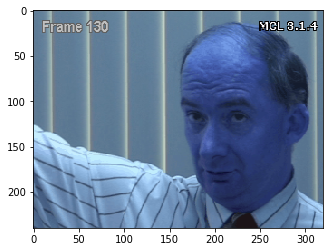

In [29]:
plt.imshow(test_data[0], cmap=plt.cm.binary)

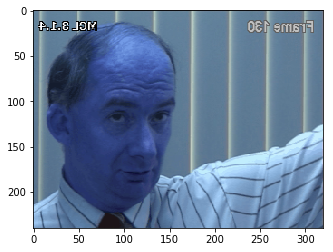

In [30]:
plt.imshow(aug_test_data[0], cmap=plt.cm.binary)

### Merge Flipped Train Images

In [44]:
aug_train_data = train_data

for i in range(67):
    aug_train_data = np.concatenate((aug_train_data,np.load('aug_train_data-' + str(i) + '.npy')))
    print(i, end='\r')
aug_train_data.shape, train_data.shape

((26782, 240, 320, 3), (13391, 240, 320, 3))

In [45]:
aug_test_data = test_data

for i in range(17):
    aug_test_data = np.concatenate((aug_test_data,np.load('aug_test_data-' + str(i) + '.npy')))
    print(i, end='\r')
aug_test_data.shape, test_data.shape

((6696, 240, 320, 3), (3348, 240, 320, 3))

### Extend Labels 

In [46]:
aug_train_labels = train_labels
aug_train_labels = np.concatenate((aug_train_labels,train_labels))

aug_test_labels = test_labels
aug_test_labels = np.concatenate((aug_test_labels,test_labels))

In [47]:
aug_train_labels.shape, train_labels.shape

((26782,), (13391,))

In [48]:
aug_test_labels.shape, test_labels.shape

((6696,), (3348,))

### Train with Augmented Data

In [49]:
try:
    del model
    print('Model cleared')
except:
    pass

try:
    keras.backend.clear_session()
    gc.collect()
    print('Session cleared')
except:
    pass

model = build_model(2, 3, 4, 0.2)
model.summary()

Model cleared
Session cleared
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pain-conv-1 (Conv2D)         (None, 240, 320, 4)       112       
_________________________________________________________________
pain-maxpool-1 (MaxPooling2D (None, 60, 80, 4)         0         
_________________________________________________________________
pain-conv-2 (Conv2D)         (None, 58, 78, 8)         296       
_________________________________________________________________
pain-maxpool-2 (MaxPooling2D (None, 14, 19, 8)         0         
_________________________________________________________________
pain-flatten-1 (Flatten)     (None, 2128)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2128)              0         
_________________________________________________________________
pain-dense-1 (Dense)         (None, 128)      

In [50]:
history = model.fit(aug_train_data, 
                    aug_train_labels, 
                    epochs=20, 
                    batch_size=128,
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])
print('\nFitting Done!')


....................
Fitting Done!


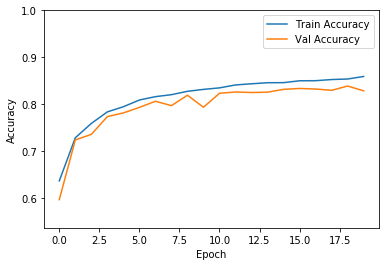

In [51]:
plot_history(history)

In [53]:
model.evaluate(aug_test_data, aug_test_labels)

6696/6696 [==============================] - 4s 636us/sample - loss: 0.3896 - acc: 0.8266 - binary_crossentropy: 0.3896


[0.38955838682759764, 0.8266129, 0.3895585]

In [54]:
predictions = model.predict(aug_test_data)

[Text(0, 0.5, 'no pain'), Text(0, 1.5, 'pain')]

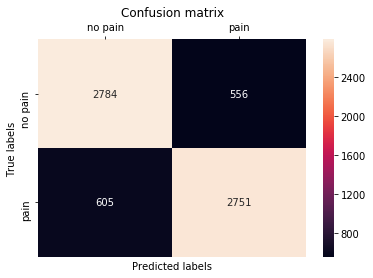

In [56]:
predictions = np.around(predictions, decimals=0)
cm = confusion_matrix(aug_test_labels, predictions)

# plot heatmap of confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
plt.title('Confusion matrix', y=1.08)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.tick_top()
ax.xaxis.set_ticklabels(['no pain', 'pain'])
ax.yaxis.set_ticklabels(['no pain', 'pain'])